# Exploring the “à la carte” Subscription Model for AAVAiL

### 1. Assimilate the business scenario and articulate testable hypotheses


AAVAIL launched using a tiered, subscription-based service which showed promise, but conversations with users, especially those outside of US markets, prompted an experiment using an à la carte approach. This experiment was carried out mostly outside of the US and there are now a couple of years of data with a few thousand active users. The data are transaction-level purchases across 38 different countries and are invoiced in batches. 

Management has nearly decided to make the switch to the new model, but they find it difficult to predict monthly revenue. Thus, a service was created to provide management with an example of what can be done given the data that has been collected to date. After exploring this data, it has been determined that a predictive model can be built to provide a prediction of revenue for the following month (so, predicting May revenue from data up to April) for the company as a whole and for each country that is participating in this consumption model. If the model projections are stable, accurate, and satisfactory to management, they just might pull the trigger and make the switch. 

Essentially, the business metric is revenue and the ask by management is to be able to accurately forecast it one month out. A testable hypothesis could be that the à la carte approach produces more revenue for AAVAiL than the tiered subscription model but that would require some A/B testing. Another testable hypothesis would be that an accurate forecast could lead to higher levels of revenue. 


### 2. State the ideal data to address the business opportunity and clarify the rationale for needing specific data

The ideal data would be generated from an experiment that was designed a bit differently from the outset. Instead of allowing each of the countries access to this à la carte approach, AAVAiL should have identified two historically similar markets within these countries and performed A/B testing where one market would keep the tiered subscription and the other would be granted access to the à la carte approach. This way, we would be able to compare the historical forecast accuracy and revenue values to a, albeit less than perfect, but as similar market as possible with the new consumption method as well as a new forecasting model. 

The data for each market would be as identical as possible and transactional in nature with timestamps for every action. For the tiered consumption location, it would contain things like subscription type and the cost associated, location, as well as an identifier for each subscriber. For the à la carte location it would contain price for each item streamed, location, and identifier for each subscriber and so on. The more descriptive information about either the better. 

From that, revenue would be the target for both markets and we would be able to see if one consumption model generates more revenue than the other as well as compare the respective forecast model accuracies.

### 3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion

Appropriate imports for the necessary functions used to ingest and preprocess the data

In [1]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]

Function to ingest all of the various JSON files

In [4]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

In [5]:
#need to replace this with DATA_DIR later
df = fetch_data('C:\\Users\\MATTBELLIO\\Desktop\\AI_Academy\\Machine_Learning_Foundation\\AI_Enterprise_Workflow_Certification\\AI_in_Production\\ai-workflow-capstone-master\\ai-workflow-capstone-master\\cs-train')

In [6]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [7]:
df.tail()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
815006,United Kingdom,16098.0,31,562271,7,3.75,22725,2,2019,2019-07-31
815007,United Kingdom,16098.0,31,562271,7,3.75,22726,12,2019,2019-07-31
815008,United Kingdom,16098.0,31,562271,7,3.75,22727,6,2019,2019-07-31
815009,United Kingdom,14056.0,31,562269,7,2.95,22090,2,2019,2019-07-31
815010,United Kingdom,15628.0,31,562163,7,1.65,22558,12,2019,2019-07-31


In [ ]:
# >600 days for total duration
# going to drop year, month and day because of invoice_day after exploration

In [8]:
df.shape

(815011, 10)

These types were inferred correctly and invoice_date was instantiated by the loading function since derived

In [9]:
df.dtypes

country                 object
customer_id            float64
day                      int64
invoice                 object
month                    int64
price                  float64
stream_id               object
times_viewed             int64
year                     int64
invoice_date    datetime64[ns]
dtype: object

It appers all nulls are in customer_id

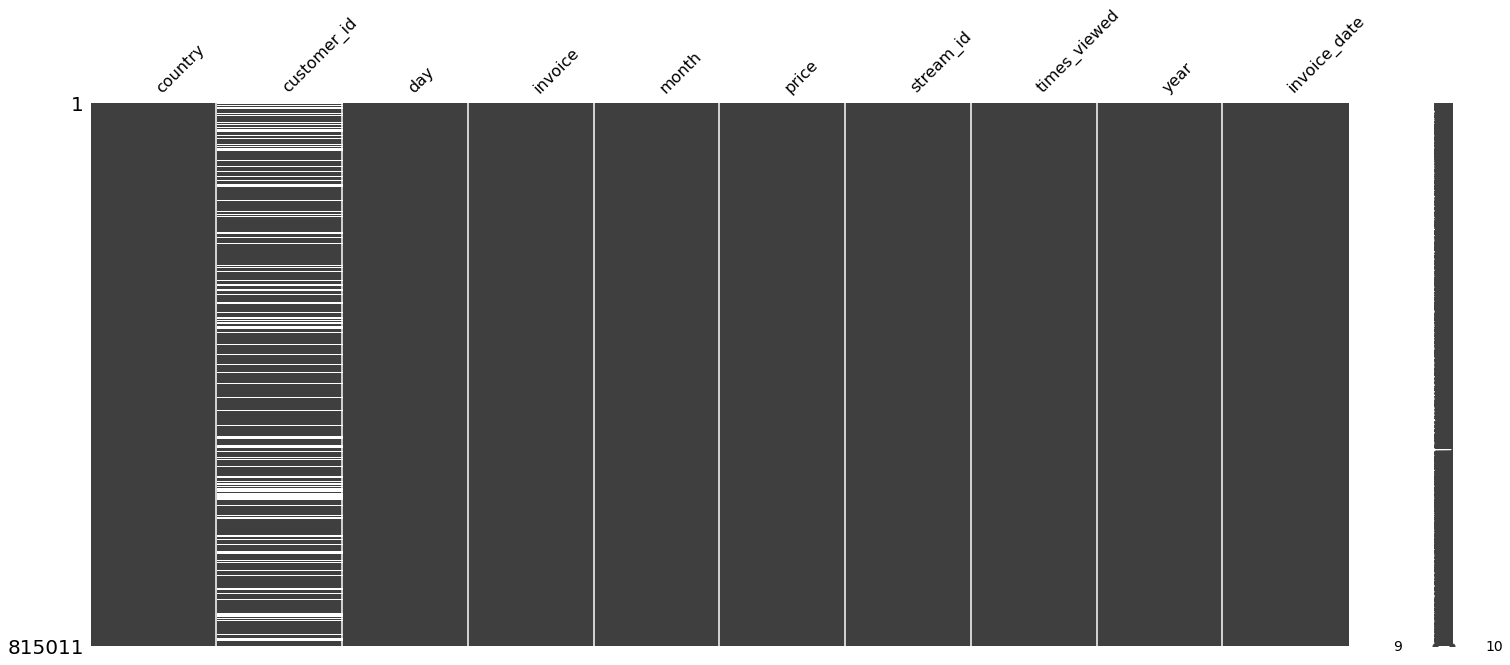

In [10]:
msno.matrix(df)
plt.show()

Since all the null values are in customer_id its not really an issue as, regardless of that value, reveneue is still attributed to someone / something on that day and we want to aggregate at the day level

Looks like the null values make up ~23% of the overall data

In [11]:
null_data = df[df.isnull().any(axis=1)]
null_data_frac = null_data.shape[0]/df.shape[0]*100

print(null_data.shape)
print(null_data_frac)

(189762, 10)
23.283366727565642


We do a check to see if there are any duplicate values in our dataset

Using duplicated() does a distinct across all columns / rows

In [12]:
duplicate_rows = df.duplicated()

We see a handful of dupes so we will remove them

In [13]:
duplicate_rows.value_counts()

False    786167
True      28844
dtype: int64

In [14]:
if True in duplicate_rows:
    df_clean = df[~duplicate_rows]

In [15]:
df_clean.shape

(786167, 10)

In [38]:
df_clean.describe()

,customer_id,day,month,price,times_viewed,year
count,603973.000000,786167.000000,786167.000000,786167.000000,786167.000000,786167.000000
mean,15320.151821,15.145463,6.457189,4.796160,5.303078,2018.255149
std,1697.323150,8.687358,3.548815,135.758379,5.146055,0.551239
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13931.000000,8.000000,3.000000,1.250000,1.000000,2018.000000
50%,15252.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16797.000000,22.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


We were instructed to limit our exploration to the top 10 revenue generating countries only so need to find them

In [16]:
grouped = df_clean.groupby(['country'])['price'].sum()

# Top 10 countries from sorted list of countries in decreasing order
top_10 = grouped.sort_values(ascending=False)[0:10]
top_10

country
United Kingdom    3.381963e+06
EIRE              1.062234e+05
Germany           4.835679e+04
France            3.966539e+04
Norway            3.833638e+04
Spain             1.589153e+04
Hong Kong         1.444137e+04
Portugal          1.318820e+04
Singapore         1.317592e+04
Netherlands       1.230615e+04
Name: price, dtype: float64

And restrict ourselves to just them

In [17]:
#restrict overall dataset to just these countries
list_top_10 = ['United Kingdom', 'EIRE', 'Germany', 'France',
               'Norway', 'Spain', 'Hong Kong', 'Portugal',
               'Singapore', 'Netherlands']
df_top_10 = df_clean[df_clean['country'].isin(list_top_10)]

In [18]:
df_top_10.shape

(769181, 10)

### 4. Investigate the relationship between the relevant data, the target and the business metric

Let's explore the main driver behind this whole investigation, price

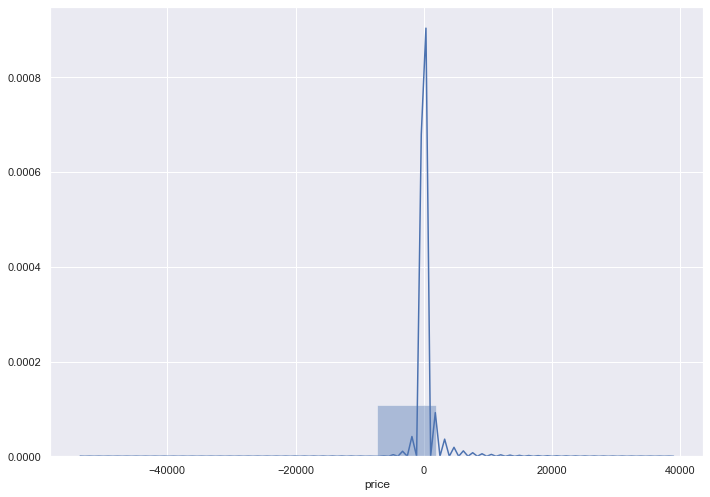

In [19]:
#why are there negative prices?
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df_top_10['price'], bins=10)

Intersetingly we see that there are both large negative prices as well as large positive ones which is odd. I can't imagine there being any item that one could stream for $20,000

In [20]:
#3 month intervals, all huge price points, maybe bulk refunds?
df_top_10[df_top_10['price'] < 0]

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
180418,United Kingdom,NaN,26,506401,4,-53594.36,B,1,2018,2018-04-26
276274,United Kingdom,NaN,16,516228,7,-44031.79,B,1,2018,2018-07-16
403469,United Kingdom,NaN,17,528059,10,-38925.87,B,1,2018,2018-10-17


In [21]:
#why are these so big? 
df_top_10[df_top_10['price'] > 20000]

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
241825,United Kingdom,17399.0,14,512770,6,25111.09,M,2,2018,2018-06-14
241828,United Kingdom,NaN,14,512771,6,25111.09,M,1,2018,2018-06-14
748141,United Kingdom,15098.0,7,556445,6,38970.00,M,1,2019,2019-06-07


Next lets explore how these prices fluctuate over time. Will there be seasonality, an upward or downward trend? 

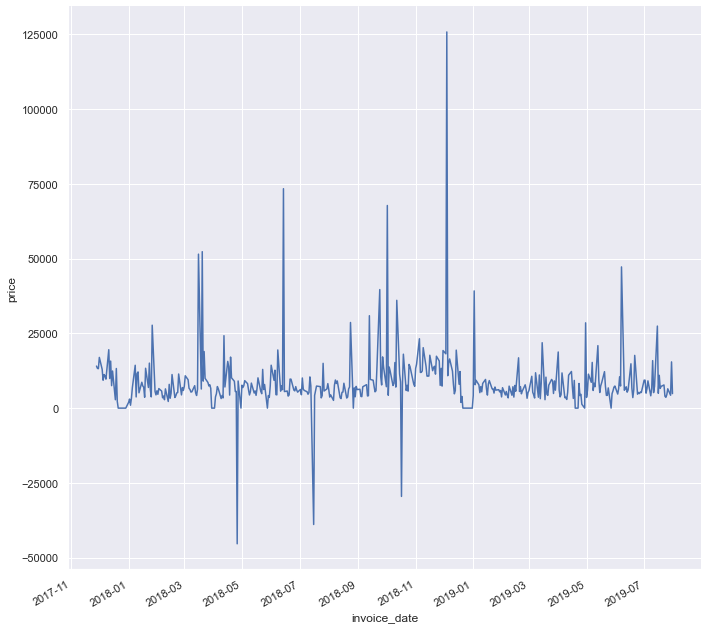

In [22]:
g = sns.relplot(x='invoice_date', y='price', data=df_top_10.groupby(pd.Grouper(key='invoice_date', freq='B')).sum().reset_index(), kind='line', height = 10)
g.fig.autofmt_xdate()

Now lets aggregate at the year level

In [23]:
#revenue by year
revenue_by_year = df_top_10[['year', 'price']].groupby('year').sum().sort_values('price', ascending=False)
revenue_by_year = revenue_by_year.rename(columns={'price': 'revenue'})
revenue_by_year = revenue_by_year.reset_index()

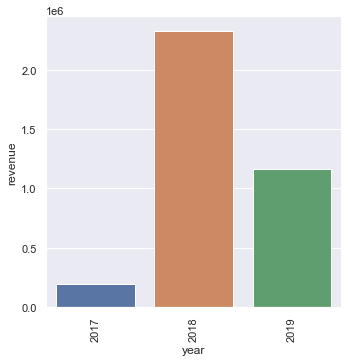

In [24]:
b = sns.catplot(x='year', y='revenue', data=revenue_by_year, kind='bar')
b.set_xticklabels(rotation=90)

Looks like 2018 was a banner year however, things have fallen off a bit in 2019 (albiet data only through June so it could match 2018 numbers)

Lets go a bit deeper and look at revenue by each country by each year

In [25]:
#revenue by country by year
revenue_by_cy = df_top_10[['country', 'price', 'year']].groupby(['country', 'year']).sum().sort_values('price', ascending=False)
revenue_by_cy = revenue_by_cy.rename(columns={'price': 'revenue'})
revenue_by_cy = revenue_by_cy.reset_index()

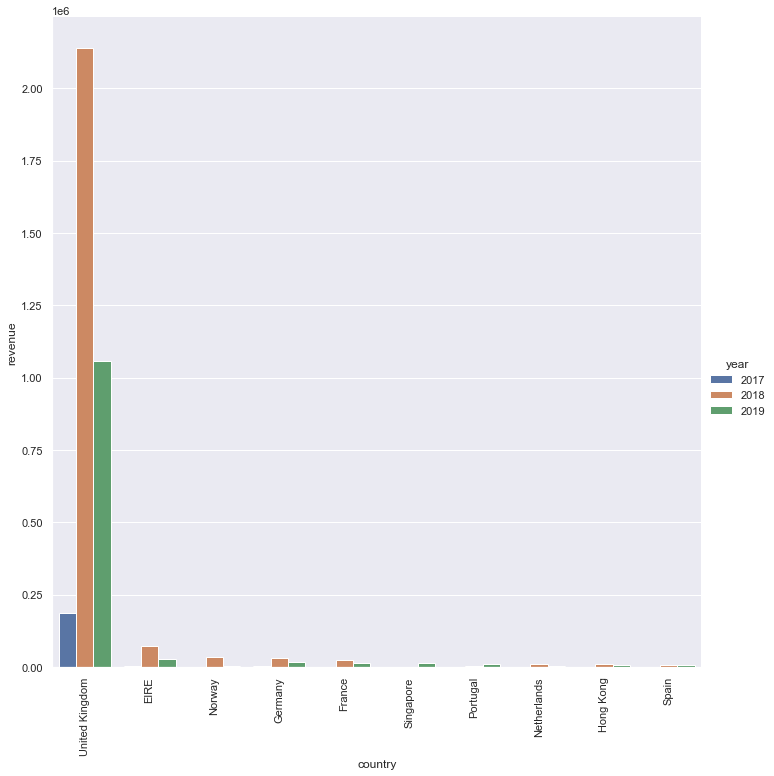

In [26]:
b = sns.catplot(x='country', y='revenue', hue = 'year', data=revenue_by_cy, kind='bar', height = 10)
b.set_xticklabels(rotation=90)

The UK is certainly the driving force here, so much so that it's skewing our graph. Let's remove them from the visualization and take a look at the other countries

In [27]:
#remove UK for reveneu by year by country as its screwing up axis

list_top_9 = ['EIRE', 'Germany', 'France',
               'Norway', 'Spain', 'Hong Kong', 'Portugal',
               'Singapore', 'Netherlands']
df_top_9 = df_clean[df_clean['country'].isin(list_top_9)]

In [28]:
#revenue by country by year for non-UK
revenue_by_cy2 = df_top_9[['country', 'price', 'year']].groupby(['country', 'year']).sum().sort_values('price', ascending=False)
revenue_by_cy2 = revenue_by_cy2.rename(columns={'price': 'revenue'})
revenue_by_cy2 = revenue_by_cy2.reset_index()

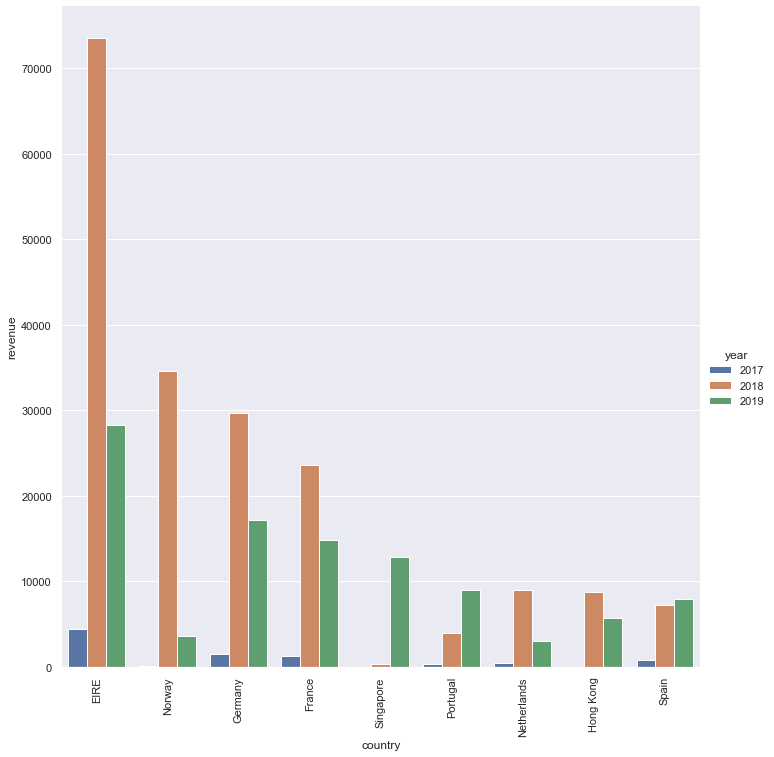

In [29]:
c = sns.catplot(x='country', y='revenue', hue = 'year', data=revenue_by_cy2, kind='bar', height = 10)
c.set_xticklabels(rotation=90)

Across the board 2018 was a huge year and it looks like 2019 is already outpacing it in a few instances like Spain, Portugal, and Singapore

Lastly, lets examine the 'times_viewed' data to see if things are in lock-step with revenue

In [30]:
#revenue by country by year
views_by_cy = df_top_10[['country', 'times_viewed', 'year']].groupby(['country', 'year']).sum().sort_values('times_viewed', ascending=False)
views_by_cy = views_by_cy.reset_index()

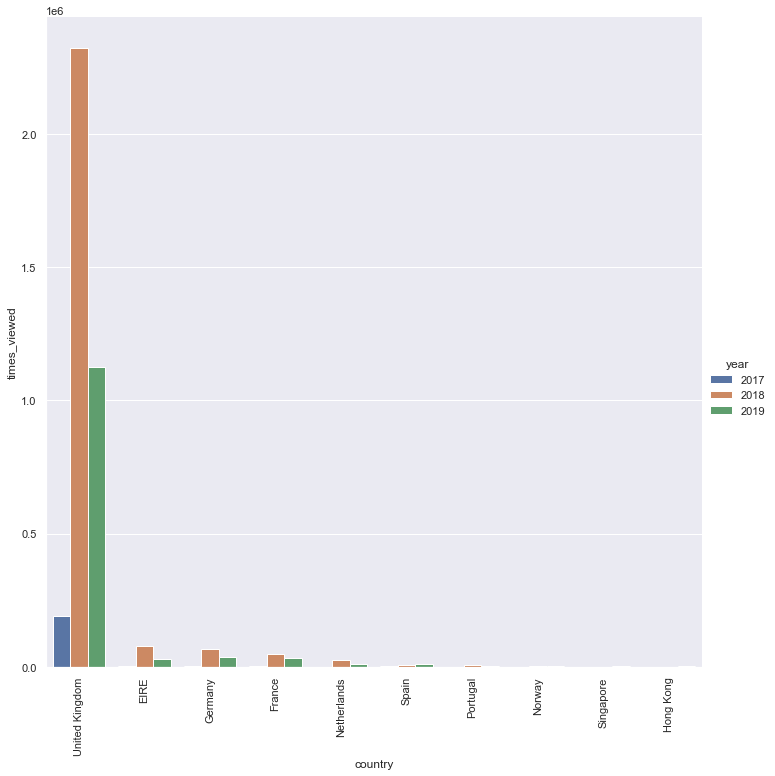

In [31]:
d = sns.catplot(x='country', y='times_viewed', hue = 'year', data=views_by_cy, kind='bar', height = 10)
d.set_xticklabels(rotation=90)

In [32]:
#revenue by country by year for non-UK
views_by_cy2 = df_top_9[['country', 'times_viewed', 'year']].groupby(['country', 'year']).sum().sort_values('times_viewed', ascending=False)
views_by_cy2 = views_by_cy2.reset_index()

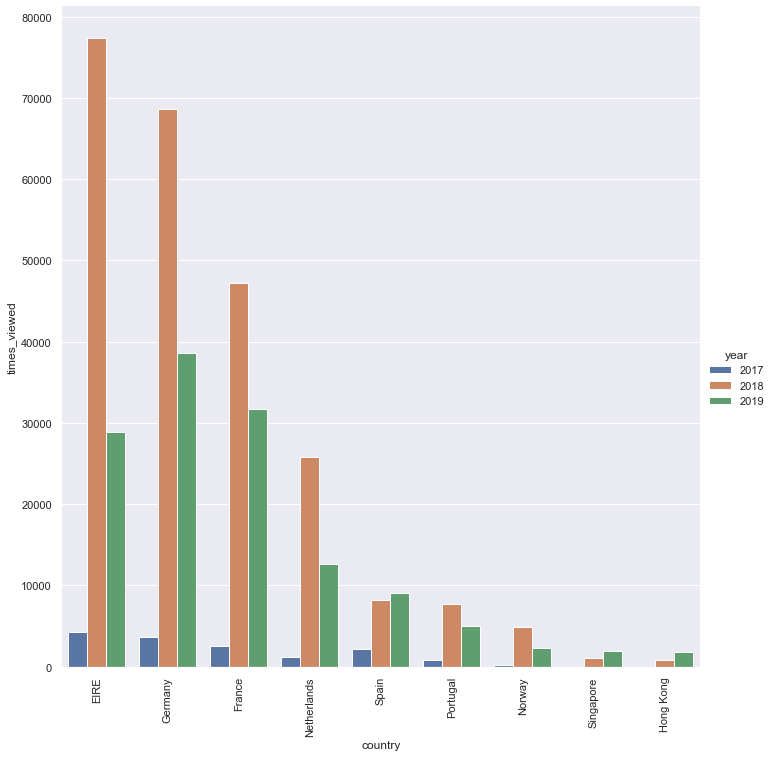

In [33]:
e = sns.catplot(x='country', y='times_viewed', hue = 'year', data=views_by_cy2, kind='bar', height = 10)
e.set_xticklabels(rotation=90)

More or less, things are which isn't suprising. What is intersting is Singapore. Essentilly the same number of 'times_viewed' year over year and yet their revenue has skyrocketed in 2019. Similarly, Portugal's 'times_viewed' is currently down in 2019 compared to 2018 but their revenue is up.

Now that we've sufficiently explored the data, we still need to transform it into a format that is useful for modeling. 

We will be using a time series approach so we need the data aggregated at the day level

In [34]:
def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)

In [35]:
df_day = convert_to_ts(df_top_10)

In [41]:
df_day.shape

(607, 7)

In [ ]:
df_day

In [36]:
df_day.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [37]:
df_day.tail()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
602,2019-06-26,1353,65,997,6410,2019-06,4863.82
603,2019-06-27,1573,77,925,9075,2019-06,5359.16
604,2019-06-28,998,69,604,5397,2019-06,3487.95
605,2019-06-29,0,0,0,0,2019-06,0.00
606,2019-06-30,581,27,423,2508,2019-06,1741.25


Lastly, lets look at the daily trends for both revenue and total views to see how they coincide

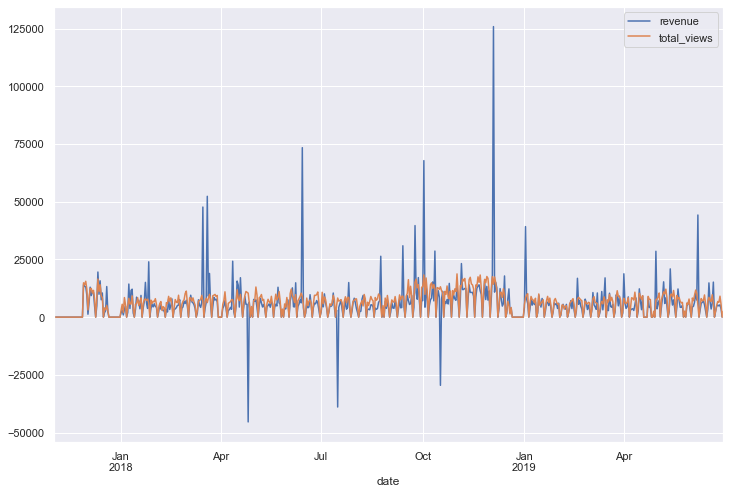

In [40]:
agg_df = df_day.groupby('date',as_index=False)[['revenue','total_views']].agg({'revenue':'sum','total_views':'sum'})
agg_df.plot(x="date", y=['revenue','total_views'], figsize = (12,8))

Looks like total_views has a weekly cadence to it which makes sense (people cant stream much during the work week but can do much more on the weekend). Interesting that there is a flat region just prior to Jan 2019

Run function for each individual country in our top 10 and save each as csv files

In [50]:
df_uk = convert_to_ts(df_top_10, country = 'United Kingdom')
df_eire = convert_to_ts(df_top_10, country = 'EIRE')
df_ger = convert_to_ts(df_top_10, country = 'Germany')
df_fr = convert_to_ts(df_top_10, country = 'France')
df_nor = convert_to_ts(df_top_10, country = 'Norway')
df_sp = convert_to_ts(df_top_10, country = 'Spain')
df_hk = convert_to_ts(df_top_10, country = 'Hong Kong')
df_port = convert_to_ts(df_top_10, country = 'Portugal')
df_sing = convert_to_ts(df_top_10, country = 'Singapore')
df_neth = convert_to_ts(df_top_10, country = 'Netherlands')

In [51]:
#df_day.to_csv('all_ts_data.csv', index = False)
df_uk.to_csv('uk_ts_data.csv', index = False)
df_eire.to_csv('eire_ts_data.csv', index = False)
df_ger.to_csv('germany_ts_data.csv', index = False)
df_fr.to_csv('france_ts_data.csv', index = False)
df_nor.to_csv('norway_ts_data.csv', index = False)
df_sp.to_csv('spain_ts_data.csv', index = False)
df_hk.to_csv('hongkong_ts_data.csv', index = False)
df_port.to_csv('portugal_ts_data.csv', index = False)
df_sing.to_csv('singapore_ts_data.csv', index = False)
df_neth.to_csv('netherlands_ts_data.csv', index = False)